<a href="https://colab.research.google.com/github/sejeong-park/Energy_Consumption/blob/main/LSTM_%EB%AA%A8%EB%8D%B8%20Global_active_power%EC%97%90%EC%A0%81%EC%9A%A9%ED%95%B4%EB%B3%B4%EC%9E%90.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torch.nn as nn
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
df=pd.read_csv('household_power_consumption_days.csv')

In [ ]:
df
#일변량 데이터


,dt,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
0,2007-01-01,2749.004,148.166,345785.73,11400.4,0.0,352.0,5880.0
1,2007-01-02,1269.236,190.342,348399.04,5348.2,0.0,348.0,6562.0
2,2007-01-03,1014.054,196.728,350722.21,4340.2,0.0,344.0,4765.0
3,2007-01-04,3259.412,202.302,345240.43,13648.6,1051.0,7597.0,10896.0
4,2007-01-05,2713.364,173.154,346313.90,11354.6,1483.0,379.0,7602.0
...,...,...,...,...,...,...,...,...
360,2007-12-27,2532.198,190.582,348640.72,10650.0,4122.0,1490.0,7960.0
361,2007-12-28,3113.052,206.800,348889.65,13004.0,1980.0,8554.0,15823.0
362,2007-12-29,3298.956,199.892,346392.96,13766.4,4836.0,2434.0,14906.0
363,2007-12-30,2558.916,178.436,348622.81,10750.6,3595.0,3597.0,13485.0


In [ ]:
data=df['Global_active_power'].values.astype(float)
valid_data_size=12 #일년의 일간 변화율 측정할 것 
train_data=data[:-valid_data_size]
valid_data=data[-valid_data_size:]

In [ ]:
train_data.shape

(353,)

In [ ]:
train_data

array([2749.004, 1269.236, 1014.054, 3259.412, 2713.364, 1508.378,
       2447.62 , 2241.36 , 1869.054, 2154.8  , 2255.194, 1461.296,
       3186.814, 3007.816, 2148.678, 1686.404, 2847.688, 1821.462,
       1480.44 , 3133.732, 3407.262, 2180.494, 1777.64 , 2987.854,
       1596.344, 1617.972, 2044.072, 3090.204, 1982.664, 1707.798,
       2363.752, 1824.76 , 1667.736, 4029.722, 3595.94 , 1645.28 ,
       1273.48 , 2328.018, 1801.414, 1620.198, 2829.328, 3571.228,
       1877.61 , 1414.546, 2498.672, 1985.346, 1702.528, 2076.912,
       3829.762, 2186.614, 3149.928, 2072.874, 3369.478, 1313.48 ,
        714.922,  501.74 ,  568.484,  518.112,  520.774,  517.564,
        515.688,  819.122, 2090.7  , 2660.332, 1246.5  , 2375.206,
       1572.132, 1272.612, 2484.712, 3480.636, 1950.668, 1290.144,
       1793.364, 1884.814, 1702.054, 2028.09 , 2371.046, 2152.518,
       2086.228, 2142.092, 1454.978, 1309.008, 2968.43 , 3336.124,
       1416.082, 1105.14 , 2333.898, 1590.406, 1402.394, 3509.

In [ ]:
valid_data

array([1949.758, 1982.576, 2611.264, 2409.048, 2257.848, 2694.968,
       2580.28 , 2532.198, 3113.052, 3298.956, 2558.916, 2216.542])

In [ ]:
from sklearn.preprocessing import MinMaxScaler
scaler=MinMaxScaler()
train_data_norm=scaler.fit_transform(train_data.reshape(-1,1))

In [ ]:
sequence_length=12 #12월까지->365일
def make_batch(input_data,sl):
  train_x=[]
  train_y=[]
  L=len(input_data)
  for i in range(L-sl):
    train_seq=input_data[i:i+sl]
    train_label=input_data[i+sl:i+sl+1]
    train_x.append(train_seq)
    train_y.append(train_label)
  return train_x,train_y

In [ ]:
#Array형태의 데이터를 파이토치 텐서로 변환
train_x,train_y=make_batch(train_data_norm, sequence_length)
tensor_x=torch.Tensor(train_x)
tensor_y=torch.Tensor(train_y)


In [ ]:
#output : (torch.Size([108, 12, 1]), torch.Size([108, 1, 1]))

In [ ]:
tensor_x.size(),tensor_y.size()


(torch.Size([341, 12, 1]), torch.Size([341, 1, 1]))

In [ ]:
class RNN(nn.Module):
    
    def __init__(self):
        super().__init__()
        self.input_vector = 1
        self.sequence_length = 365
        self.output_vector = 100
        self.num_layers = 4
        
        self.lstm = nn.LSTM(input_size=self.input_vector, hidden_size=self.output_vector, num_layers=self.num_layers, batch_first=True)
        self.linear = nn.Sequential(
            nn.Linear(self.output_vector, 50),
            nn.Linear(50, 30),
            nn.Linear(30, 10),
            nn.Linear(10,1)
        )
        
    def forward(self, x):
        output, _ = self.lstm(x) #(hidden, cell) 데이터는 사용하지 않음
        return self.linear(output[:,-1,:])
model = RNN()

In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.MSELoss()
epochs = 501
for i in range(epochs):
    model.train()
    
    output = model(tensor_x)
    loss = criterion(output, tensor_y.view(-1,1))
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    if i%25 == 0:
        print('Epoch {}, Loss {:.5f}'.format(i, loss.item()))

Epoch 0, Loss 0.06470
Epoch 25, Loss 0.02895
Epoch 50, Loss 0.02889
Epoch 75, Loss 0.02519
Epoch 100, Loss 0.02231
Epoch 125, Loss 0.02003
Epoch 150, Loss 0.01834
Epoch 175, Loss 0.01720
Epoch 200, Loss 0.01629
Epoch 225, Loss 0.01393
Epoch 250, Loss 0.01240
Epoch 275, Loss 0.01083
Epoch 300, Loss 0.00881
Epoch 325, Loss 0.00771
Epoch 350, Loss 0.00641
Epoch 375, Loss 0.00565
Epoch 400, Loss 0.00492
Epoch 425, Loss 0.00359
Epoch 450, Loss 0.00339
Epoch 475, Loss 0.00234
Epoch 500, Loss 0.00402


In [ ]:
valid_data_norm=train_data_norm[-valid_data_size:]
valid_x,_=make_batch(valid_data_norm,sequence_length)


In [ ]:
valid_data_norm

array([[0.54926965],
       [0.56445184],
       [0.43644549],
       [0.57202556],
       [0.39408723],
       [0.4585294 ],
       [0.4900606 ],
       [0.67917241],
       [0.68546118],
       [0.44595285],
       [0.65096153],
       [0.54496365]])

In [ ]:
model.eval()
with torch.no_grad():
  valid_tensor=torch.Tensor(valid_x)
  predict=model(valid_tensor)
predict=predict.data.numpy()
actual_predictions=scaler.inverse_transform(predict)

RuntimeError: ignored

NameError: ignored

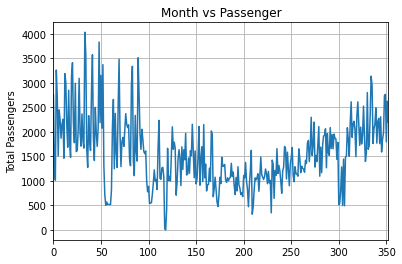

In [ ]:
x=np.arange(120,132,1)
plt.title('Month vs Passenger')
plt.ylabel('Total Passengers')
plt.grid(True)
plt.autoscale(axis='x',tight=True)
plt.autoscale(axis='x',tight=True)
plt.plot(df['Global_active_power'][0:353])
plt.plot(x,actual_predictions)
plt.show()